In [3]:
# Recommandation system

In [10]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from utils import get_mat_sparsity
from pyspark.sql.functions import explode
from pyspark.sql.functions import col

In [5]:
sc = pyspark.SparkContext('local[*]')

In [6]:
ratingsPath = 'datasets/ratings.csv'
moviesPath  = 'datasets/movies.csv'

In [210]:
spark = SparkSession.builder.appName('Recommendations').getOrCreate()
movies = spark.read.csv(moviesPath,header=True)
movies.printSchema()
ratings = spark.read.csv(ratingsPath,header=True)
ratings.printSchema()
print(ratings.count())
ratings=ratings.drop('timestamp')
movies.show(5)
ratings.show(5)

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)

100004
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|     31|   2.5|
|     1|   1029|   3.0|
|     1|   1061|   3.0|
|     1|   1129|   2.0|
|     1|   1172|   4.0|
+------+-------+------+
on

In [11]:
movie_ratings = ratings.join(movies, ['movieId'], 'left')
movie_ratings = movie_ratings.withColumn("userId", ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", ratings["rating"].cast('float'))
movie_ratings.show(5)
#sparsity
get_mat_sparsity(movie_ratings)

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|     31|     1|   2.5|Dangerous Minds (...|               Drama|
|   1029|     1|   3.0|        Dumbo (1941)|Animation|Childre...|
|   1061|     1|   3.0|     Sleepers (1996)|            Thriller|
|   1129|     1|   2.0|Escape from New Y...|Action|Adventure|...|
|   1172|     1|   4.0|Cinema Paradiso (...|               Drama|
+-------+------+------+--------------------+--------------------+
only showing top 5 rows

The ratings dataframe is  98.36% sparse.


In [12]:
#split train and test
(train, test) = movie_ratings.randomSplit([0.8, 0.2], seed = 2020)
train.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [13]:
# ALS model
als = ALS(
         userCol="userId", 
         itemCol="movieId",
         ratingCol="rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

In [18]:
param_grid = ParamGridBuilder()             .addGrid(als.rank, [10, 25, 50, 100])             .addGrid(als.regParam, [.01, .05, .1, .15])             .build()
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="rating", 
           predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)
model = cv.fit(train)
best_model = model.bestModel

print("**Best Model**")
print("  Rank:", best_model._java_obj.parent().getRank())
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

Num models to be tested:  16
**Best Model**
  Rank: 100
  MaxIter: 10
  RegParam: 0.15


In [19]:
als = ALS(
        maxIter=10,
        regParam=0.15,
        rank=50,
        userCol='userId',
        itemCol='movieId',
        ratingCol='rating',
        nonnegative=True,
        implicitPrefs=False,
        coldStartStrategy='drop'
)
model = als.fit(train)

In [20]:
test_predictions = model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.9065392864507144


In [21]:
recommendations = model.recommendForAllUsers(5)
recommendations.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[83411, 5.076339...|
|   463|[[67504, 5.065177...|
|   496|[[65037, 5.208692...|
|   148|[[67504, 5.677142...|
|   540|[[67504, 5.332522...|
|   392|[[67504, 4.417254...|
|   243|[[67504, 4.991922...|
|   623|[[67504, 5.507062...|
|    31|[[67504, 5.444722...|
|   516|[[83411, 5.072468...|
|   580|[[83411, 4.903239...|
|   251|[[83411, 5.794228...|
|   451|[[67504, 5.118748...|
|    85|[[106471, 4.63079...|
|   137|[[65037, 5.019008...|
|    65|[[83411, 5.554767...|
|   458|[[65037, 4.517281...|
|   481|[[67504, 5.959940...|
|    53|[[2433, 4.258239]...|
|   255|[[83411, 5.717262...|
+------+--------------------+
only showing top 20 rows



In [43]:
nrecommendations = recommendations    .withColumn("rec_exp", explode("recommendations"))    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

In [44]:
nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|   471|  83411|5.0763397|
|   471|  67504|5.0763397|
|   471|  83318|5.0763397|
|   471|  65037| 4.935619|
|   471| 132333|4.7528434|
|   463|  67504| 5.065177|
|   463|  83411| 5.065177|
|   463|  83318| 5.065177|
|   463|  54328|4.5594735|
|   463|  26400| 4.558659|
+------+-------+---------+



In [46]:
user=nrecommendations.join(movies, on='movieId').filter('userId = 77')

In [54]:
userRated=movie_ratings.filter('userId = 77').sort('rating',ascending=False).limit(5)

In [241]:
picUsersRecommendation=[]
userRated=[]
usersIds=[7,77,99]
for i in range(0,3):
    user=nrecommendations.join(movies, on='movieId').filter('userId = '+ str(usersIds[i]))
    userRating=movie_ratings.filter('userId = '+ str(usersIds[i])).sort('rating',ascending=False).limit(5)
    picUsersRecommendation.append(user.toPandas())
    userRated.append(userRating.toPandas())

In [48]:
result=nrecommendations.join(movies, on='movieId')

In [28]:
result.repartition(1).write.csv('output/ouput.csv',header=True)

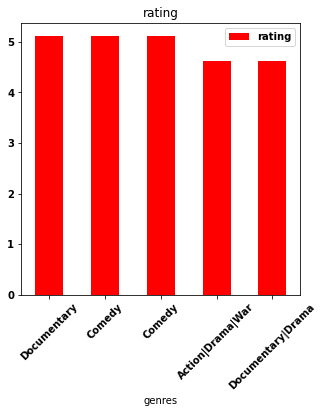

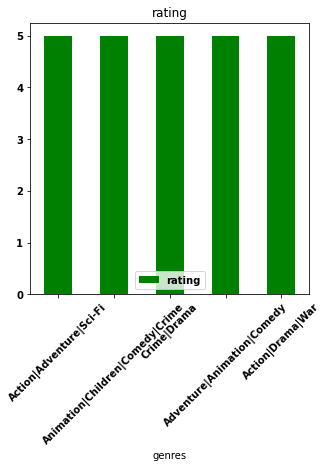

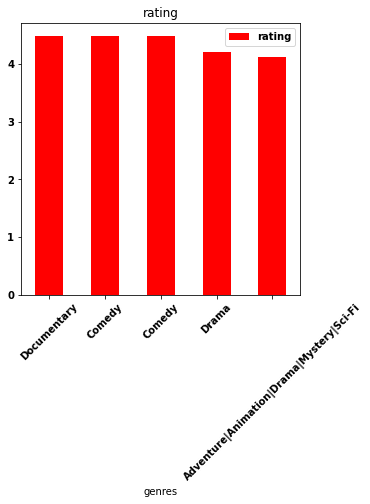

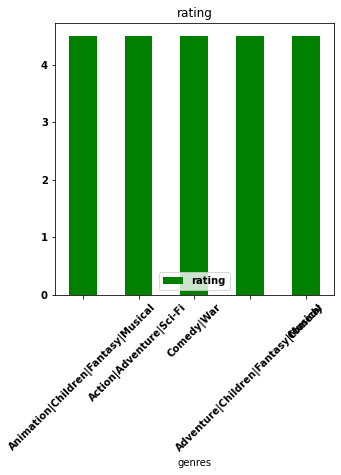

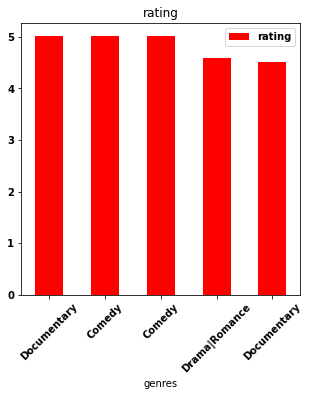

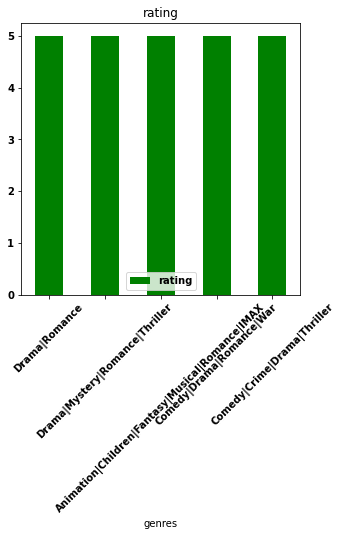

In [242]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)
for i in range(0,3):
    fig=pd.DataFrame(picUsersRecommendation[i])
    x_labels = fig['genres'].values
    y_labels = fig['rating'].values
    df = pd.DataFrame({'genres': x_labels,'rating': y_labels})
    df.plot.bar(x='genres',y='rating',subplots=True,color='red',figsize=(5,5),rot=45)

    fig=pd.DataFrame(userRated[i])
    x_labels = fig['genres'].values
    y_labels = fig['rating'].values
    df = pd.DataFrame({'genres': x_labels,'rating': y_labels})
    df.plot.bar(x='genres',y='rating',subplots=True,color='green',figsize=(5,5),rot=45)


+-------+------+---------+--------------------+-----------------+
|movieId|userId|   rating|               title|           genres|
+-------+------+---------+--------------------+-----------------+
|  83411|   471|5.0763397|         Cops (1922)|           Comedy|
|  67504|   471|5.0763397|Land of Silence a...|      Documentary|
|  83318|   471|5.0763397|    Goat, The (1921)|           Comedy|
|  65037|   471| 4.935619|        Ben X (2007)|            Drama|
| 132333|   471|4.7528434|         Seve (2014)|Documentary|Drama|
|  67504|   463| 5.065177|Land of Silence a...|      Documentary|
|  83411|   463| 5.065177|         Cops (1922)|           Comedy|
|  83318|   463| 5.065177|    Goat, The (1921)|           Comedy|
|  54328|   463|4.5594735|My Best Friend (M...|           Comedy|
|  26400|   463| 4.558659|Gates of Heaven (...|      Documentary|
+-------+------+---------+--------------------+-----------------+

+-----------------+----+----+
|           genres|best|mean|
+--------------

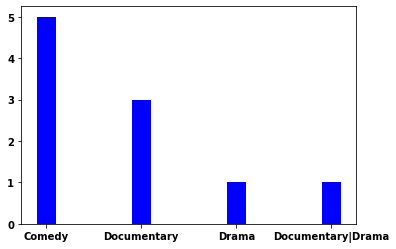

In [231]:
bestGender=nrecommendations.join(movies, on='movieId').limit(10)
from pyspark.sql.functions import col,when,count

bestGender.show()
BestAndWorst=bestGender.groupBy("genres").agg(
    count(when(col("rating") >= 3.0, True)).alias('best'),
    count(when(col("rating") <= 2.9, True)).alias('mean'))


BestAndWorst.show()
BestAndWorst=pd.DataFrame(BestAndWorst.toPandas())

x_labels = BestAndWorst['genres'].values
y_labels = BestAndWorst['best'].values

ax = plt.subplot(111)
ax.bar(x_labels, y_labels, width=0.2, color='b', align='center')

plt.show()

In [239]:
bestFilms=nrecommendations.join(movies, on='movieId')

bestFilms=bestFilms.groupBy("title").agg(
    count(when(col("rating") >= 3.0, True)).alias('best'),
    count(when(col("rating") <= 2.9, True)).alias('mean')).sort('best',ascending=False)


bestFilms.show()
bestFilms=pd.DataFrame(bestFilms.toPandas())

x_labels = bestFilms['title'].values
print(x_labels[:10])

+--------------------+----+----+
|               title|best|mean|
+--------------------+----+----+
|         Cops (1922)| 591|   0|
|Land of Silence a...| 584|   0|
|    Goat, The (1921)| 571|   0|
|        Ben X (2007)| 363|   0|
|My Best Friend (M...| 244|   0|
|Gates of Heaven (...| 153|   0|
|Cameraman, The (1...|  95|   0|
|One Piece Film: S...|  79|   0|
|Navigator, The (1...|  61|   0|
|Dylan Moran: Mons...|  56|   0|
|Vampyros Lesbos (...|  48|   0|
|Hachiko: A Dog's ...|  20|   1|
|         Seve (2014)|  17|   0|
|Passage to India,...|  17|   0|
|No Holds Barred (...|  15|   0|
|  Cool as Ice (1991)|  14|   0|
|Victory (a.k.a. E...|  12|   0|
|Big Easy, The (1987)|  11|   0|
|Love Is a Many-Sp...|  10|   0|
|     Undertow (2004)|  10|   0|
+--------------------+----+----+
only showing top 20 rows

['Cops (1922)'
 'Land of Silence and Darkness (Land des Schweigens und der Dunkelheit) (1971)'
 'Goat, The (1921)' 'Ben X (2007)'
 'My Best Friend (Mon meilleur ami) (2006)' 'Gates o